### 1. Importing libraries and dataset

In [0]:

!pip install bert-tensorflow

import tensorflow as tf
from tensorflow.keras import backend as K
import warnings

import tensorflow_hub as hub
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

Using TensorFlow backend.


In [0]:
data = pd.read_csv('Tweets.csv')

### 2. Initial look at the data

In [0]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


[]

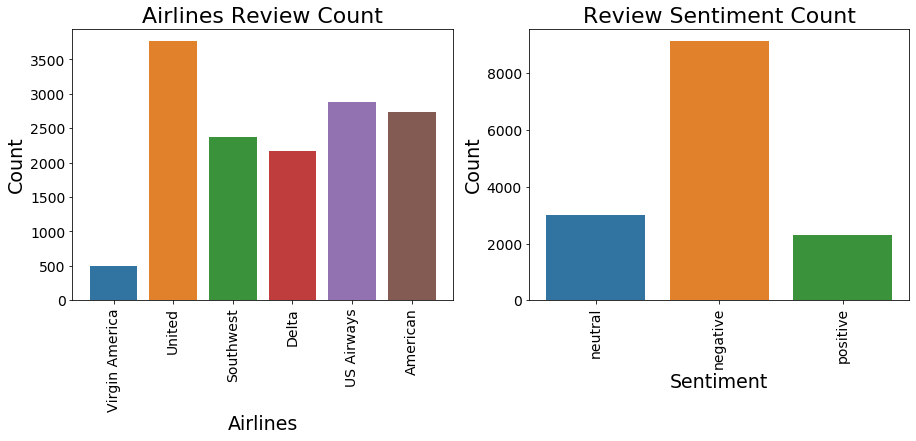

In [0]:
figsize=(15, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

plt.subplot(121)
sns.countplot(x=data["airline"])
plt.title("Airlines Review Count")
plt.xticks(rotation=90)
plt.xlabel("Airlines")
plt.ylabel("Count")
plt.plot()

plt.subplot(122)
sns.countplot(data["airline_sentiment"])
plt.title("Review Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.plot()

In [0]:
# Mostly the data is represented as a negative class, but we could 
# deal with that by changing a class weight to stabilize a training process

def class_weight_balance(y):
  get_weights = compute_class_weight('balanced', np.unique(y), y)
  return get_weights

In [0]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


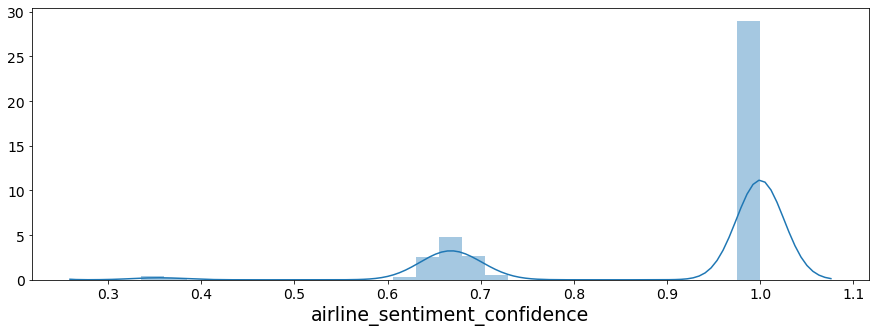

In [0]:
# Another aspect of sentiment is the confidence of the airline about provided
# sentiment score. Obviosuly this associates with unsusual language that might
# confuse about intention of a customer. Apparently we should use only part of the dataset

confidence = data['airline_sentiment_confidence']
sns.distplot(confidence)
plt.show()


In [0]:
# There is a small fraction of confidence lower than 0.5, so we could
# disregard with this part to avoid possible classification 

data = data[data['airline_sentiment_confidence'] > 0.5]
data = data.reset_index()

### 3. Text preprocessing

In [0]:
# In this project we are dealing with the mixed data. Besides 
# some characteristics of the tweets, there is some text provided
# of each sentiment. In means that we should start with a text preprocessing.
# Let's take a look on the samples in the text section

print(data['text'][0])
print(data['text'][2])
print(data['text'][3])
print(data['text'][4])

@VirginAmerica What @dhepburn said.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


In [0]:
# We could notice some freedom in style of expressing that 
# makes the difference comparing with other tasks
# Firstly let's make some preprocessing of the text 
# to make a general view for a further training

def preprocess(text):
  for i in range(len(text)):
    text[i] = BeautifulSoup(text[i], "lxml").get_text()
    text[i] = text[i].lower()
    text[i] = re.sub("[^a-zA-Z]", " ", text[i])
    text[i] = re.sub("\s+", " ", text[i])
  return text

In [0]:
data.reset_index()
data['text'] = preprocess(data['text'])

In [0]:
# If we look deeply at the dataset, basically the general part
# of our data do not have an explanatory power of tweet sentiment, so we will 
# concetrate on the text part

y = data['airline_sentiment']
x = data['text']

lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(y))

max_words = len(set(" ".join(x).split()))
max_len = x.apply(lambda x: len(x)).max()

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
train_seq = tokenizer.texts_to_sequences(x)
train_seq = sequence.pad_sequences(train_seq, maxlen=max_len)

x_train, x_test, y_train, y_test = train_test_split(train_seq, Y, test_size=0.2)
print(max_len)

176


### 4. Model training

#### 4.1 RNN

In [0]:
# Build the LSTM
sess = tf.Session()
lstm_input = tf.keras.layers.Input(shape=(max_len,), name="lstm_input")
embeddings = tf.keras.layers.Embedding(max_len, 768, trainable = True)(lstm_input)
lstm_layer = tf.keras.layers.LSTM(256)(embeddings)
NN_layer = tf.keras.layers.Dense(512, activation='relu')(lstm_layer)
pred = tf.keras.layers.Dense(3, activation='softmax')(NN_layer)
model_lstm = tf.keras.models.Model(inputs=lstm_input, outputs=pred)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
K.set_session(sess)
class_weights_coef = class_weight_balance(y_train.flatten())

verbose = 1
epochs = 10
batch_size = 128

model1 = model_lstm.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    class_weight =class_weights_coef
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 176)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 176, 768)          135168    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               1049600   
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 1,317,891
Trainable params: 1,317,891
Non-trai

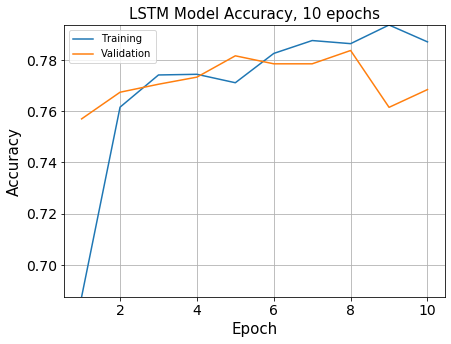

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.plot([i+1 for i in model1.epoch], model1.history['acc'])
plt.plot([i+1 for i in model1.epoch], model1.history['val_acc'])
ylim_pad = [0 , 0]

y1 = model1.history['acc']
y2 = model1.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]



plt.title('LSTM Model Accuracy, 10 epochs', fontsize = 15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.show()

In [0]:
# As we might see it is enough to stop training on the 6th or 7th epoch

#### 4.2 BERT Custom Model(switching to TPU runtime, if needed)

In [0]:
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
data = pd.read_csv('Tweets.csv')
data = data[data['airline_sentiment_confidence'] > 0.5]
data = data.reset_index()
data['text'] = preprocess(data['text'])

In [0]:
y = data['airline_sentiment']
x = data['text']
lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2)
max_len = x.apply(lambda x: len(x)).max() 
print(max_len)

176


In [0]:
max_length = max_len
#Train data 
train_text = x_train.tolist()
train_text = [' '.join(t.split()[0:max_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = y_train

#Test data
test_text = x_test.tolist()
test_text = [' '.join(t.split()[0:max_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = y_test


In [0]:
# Preprocessing and preparing data for BERT

In [0]:
sess = tf.Session()



class PaddingInputExample(object):
    """ """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):

        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=max_length):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=max_length):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels)
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

In [0]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_len)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_len)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
# Instantiate the custom Bert Layer defined above
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:

max_seq_length = max_length
in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]


sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
bert_output = BertLayer(n_fine_tune_layers=3)(bert_inputs)
# Build the rest of the classifier 
dense = tf.keras.layers.Dense(512, activation='relu')(bert_output)
pred = tf.keras.layers.Dense(3, activation='softmax')(dense)
model_bert = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
model_bert.compile(loss='categorical_crossentropy', 
                   optimizer='sgd', 
                   metrics=['accuracy'])
model_bert.summary()

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
K.set_session(sess)
class_weights_coef = class_weight_balance(Y.flatten())

model2 = model_bert.fit(
    [train_input_ids, train_input_masks, train_segment_ids],
    train_label,
    validation_data=(
        [test_input_ids, test_input_masks, test_segment_ids],
        test_label,
    ),
    epochs=15,
    batch_size=64,
    class_weight =class_weights_coef
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 176)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 176)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 176)]        0                                            
__________________________________________________________________________________________________
bert_layer_5 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

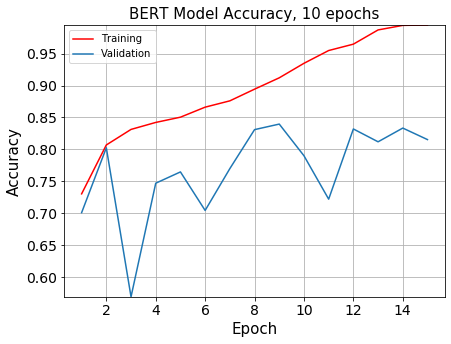

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.plot([i+1 for i in model2.epoch],model2.history['acc'], color = 'red')
plt.plot([i+1 for i in model2.epoch],model2.history['val_acc'])
ylim_pad = [0 , 0]

y1 = model2.history['acc']
y2 = model2.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.title('BERT Model Accuracy, 10 epochs', fontsize = 15)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.show()

In [0]:
print(max(model2.history['val_acc']))
print(max(model1.history['val_acc']))

0.839639
0.78375566
